In [1]:
!pip install datasets tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 558.8/558.8 kB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.7/32.7 MB 46.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 42.6 MB/s eta 0:00:00


In [2]:
from datasets import load_dataset
from collections import Counter
import pandas as pd
import random
import re
import os

/Users/shuyuezhang/opt/anaconda3/envs/test_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
from datasets import load_dataset

# 加载英语版本的 XNLI
xnli_en = load_dataset("xnli", "en")

# 加载越南语版本的 XNLI
xnli_vi = load_dataset("xnli", "vi")

# 提取训练集
en_train = xnli_en['train']
vi_train = xnli_vi['train']

# 合并 premise 和 hypothesis
def combine_text(example):
    return {
        "text": example["premise"] + " [SEP] " + example["hypothesis"],
        "label": example["label"]
    }

en_data = en_train.map(combine_text)
vi_data = vi_train.map(combine_text)

# 转成 pandas DataFrame
df_en = pd.DataFrame(en_data)[["text", "label"]]
df_vi = pd.DataFrame(vi_data)[["text", "label"]]

Map: 100%|██████████| 392702/392702 [00:11<00:00, 33359.72 examples/s]


In [6]:
!pip install tokenizers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 32.8 MB/s eta 0:00:00


# BPE

In [7]:
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.normalizers import Lowercase, NFD, StripAccents, Sequence as NormalizerSequence
from tokenizers.processors import TemplateProcessing
from tokenizers import normalizers

# 准备训练语料：保存到 txt 文件
with open("bpe_en.txt", "w", encoding="utf-8") as f:
    for line in df_en["text"]:
        f.write(line + "\n")

# 初始化空 tokenizer
tokenizer = Tokenizer(BPE())

# 添加预处理（比如小写 + 去除重音）
tokenizer.normalizer = NormalizerSequence([NFD(), Lowercase(), StripAccents()])

# 添加空格分词器
tokenizer.pre_tokenizer = Whitespace()

# 训练器：设置 vocab size
trainer = BpeTrainer(vocab_size=10000, special_tokens=["[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]"])

# 训练
tokenizer.train(["bpe_en.txt"], trainer)

# 保存 tokenizer
tokenizer.save("bpe_tokenizer_en.json")


In [8]:
# 加载分词器并准备 Counter
from tokenizers import Tokenizer
from collections import Counter

# 加载训练好的 BPE 分词器
tokenizer = Tokenizer.from_file("bpe_tokenizer_en.json")

# 分词 + 统计词频
token_counts = Counter()

for line in df_en["text"]:
    encoding = tokenizer.encode(line)
    tokens = encoding.tokens
    token_counts.update(tokens)

# 排序
sorted_tokens = token_counts.most_common()

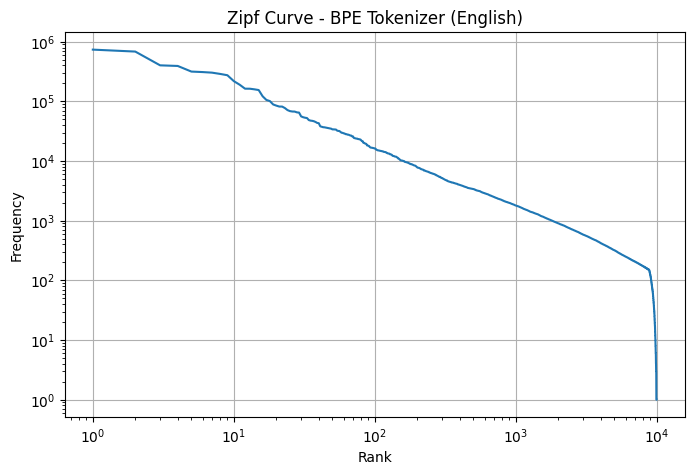

In [10]:
# 画 Zipf 曲线
import matplotlib.pyplot as plt

# 准备 rank & freq
ranks = list(range(1, len(sorted_tokens) + 1))
frequencies = [freq for _, freq in sorted_tokens]

# 绘图
plt.figure(figsize=(8, 5))
plt.loglog(ranks, frequencies)
plt.xlabel("Rank")
plt.ylabel("Frequency")
plt.title("Zipf Curve - BPE Tokenizer (English)")
plt.grid(True)
plt.show()

In [11]:
# BPE 分词器加载 & 分词生成 tokens_str
from tokenizers import Tokenizer
tokenizer = Tokenizer.from_file("bpe_tokenizer_en.json")

# 把每行 text 分词后转成字符串
def tokenize_to_str(text):
    return " ".join(tokenizer.encode(text).tokens)

df_en["tokens_str"] = df_en["text"].apply(tokenize_to_str)

In [12]:
#构建 TF-IDF 特征矩阵
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df_en["tokens_str"])
y = df_en["label"]

In [13]:
def tokenize_with_method(df, tokenizer_obj, method_name):
    """
    使用给定分词器(HuggingFace Tokenizer 对象)对 df["text"] 分词，生成 tokens_str 列。
    method_name: 用于保存图或输出时标记分词方法
    """
    df_copy = df.copy()
    df_copy[f"tokens_str_{method_name}"] = df_copy["text"].apply(
        lambda x: " ".join(tokenizer_obj.encode(x).tokens)
    )
    return df_copy
